In [242]:
from itertools import combinations
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib_venn import venn3

import sys
sys.path.append('../mchem_functions/')
import multivariate_functions as mvf
import PCA_functions as pcf

In [ ]:
def standardise(matrix:np.ndarray):
    return np.divide(np.subtract(matrix,np.mean(matrix,axis=0)) , np.std(matrix,axis=0))

def check_vif(X, threshold:int|float=5):
    # Calculate VIF for each feature
    vif_data = np.array([variance_inflation_factor(X, i) for i in range(np.shape(X)[1])])

    indx_to_keep = np.where(vif_data < threshold)[0]
    filtered_X = X[:,indx_to_keep]

    return vif_data, indx_to_keep, filtered_X

def do_pca(matrix:np.ndarray,n_components:int=None):
    Y = matrix.copy()
    Y_c = np.subtract(Y,np.mean(Y,axis=0))
    # n is number of observations (samples)
    n = np.shape(Y)[0]

    S = (1/(n-1)) * (Y_c.T @ Y_c)
    
    eigvals, eigvecs = la.eigh(S)
    U = eigvecs # loadings

    # negative_close_to_zero = np.isclose(eigvals, 0)
    eigvals[np.isclose(eigvals, 0)] = 0

    # eigvals might not be ordered, so we first sort them, then analogously sort the eigenvectors by the ordering of the eigenvalues too
    idxs_descending = eigvals.argsort()[::-1]
    eigvals = eigvals[idxs_descending]
    U = U[:, idxs_descending]

    proportion_explained = eigvals / np.sum(eigvals)

    # scores F
    F = Y_c @ U
    F[np.isclose(F, 0)] = 0

    max_n_n_components = len(eigvals) - len(np.where(eigvals==0)[0])

    if n_components == None:
        n_components = max_n_n_components

    elif n_components > max_n_n_components:
        print('The max number of PCs is min(np.shape(matrix)[0]-1,np.shape(matrix)[1])\nn_components will be now set at that value')
        n_components = max_n_n_components

    U = U[:, :n_components]
    eigvals = eigvals[:n_components]
    proportion_explained = proportion_explained[:n_components]
    F = F[:, :n_components]
    
    return eigvals, proportion_explained, U, F

def ols(Y:np.ndarray,X:np.ndarray):
    return X @ la.inv(X.T @ X) @ X.T @ Y

def rda(Y:np.ndarray,X:np.ndarray,confidence:float=0.95,verbose:bool=True):
    '''
    
    P. Legendre and L. Legendre, in Developments in Environmental Modelling, ed. P. Legendre and L. Legendre, Elsevier, 2012, vol. 24, ch. 11, pp. 625-710.
    '''

    assert np.shape(Y)[0] == np.shape(X)[0], 'Y must have n objects and p variables (n x p X must have n objects and m variables (n x m).'
    n, p = np.shape(Y)
    m = np.shape(X)[1]
    assert m != (n-1), 'm >= (n-1): The system is overdetermined. If m == (n-1), R^2 cannot be calculated'
    if m > n-1: print('m > n-1: the system is overdetermined, X has too many explanatory variables')

    # Center the matrices Y and X
    Y_c = np.subtract(Y,np.mean(Y,axis=0))

    # Do Ordinary least squares (OLS) on X and Y
    Y_hat = ols(Y_c,X)

    # Y_hat = la.lstsq(Y_c,X)[0]

    # Perform PCA on Y_hat to find the canonical values
    eigvals_can, _, U_can, Z_can = do_pca(Y_hat)

    # Calculate the residual values
    Y_res = np.subtract(Y_c,Y_hat)

    # Perform PCA on Y_res to find the non-canonical values
    eigvals_noncan, _, U_noncan, Z_noncan = do_pca(Y_res)

    # Calculate the proportion exaplained from the sum of the eigenvalues we have
    all_eigvals_sum = np.sum( np.append(eigvals_can,eigvals_noncan) )
    proportion_explained_can = eigvals_can / all_eigvals_sum
    proportion_explained_noncan = eigvals_noncan / all_eigvals_sum

    # Calculate the overall canonical R^2
    R2_YX = np.divide( np.var(Y_hat), np.var(Y_c) )
    # Calculate the overall adjusted R^2
    R2_a = 1 - (1 - R2_YX) * ( (n-1) / (n-m-1) )

    # Calculate the r for each axis
    F = Y_c @ U_can
    r_k = np.zeros(np.shape(F)[1])
    for i in range(np.shape(F)[1]):
        r_k[i] = scipy.stats.linregress(F[:,i], Z_can[:,i])[2]

    # Get the contribution of the explanatory variables X to the canonical ordination axes
    R_XZ = np.zeros((np.shape(X)[1],np.shape(Z_can)[1]))
    for i in range(np.shape(R_XZ)[0]):
        for j in range(np.shape(R_XZ)[1]):
            R_XZ[i,j] = scipy.stats.linregress(X[:,i], Z_can[:,j])[2]
            
    # Get the matrix of biplot scores in scaling type 1 (BS_1) for the explanatory variables
    BS_1 = np.zeros_like(R_XZ)
    for i in range(np.shape(BS_1)[1]):
        BS_1[:,i] = R_XZ[:,i] * np.sqrt(proportion_explained_can)[i]

    # Run the F-test
    # (1) Get the degrees of freedom
    # (1.a) in the case of standardised values
    if np.all(np.isclose(Y,standardise(Y))): v1 , v2 = (m*p) , (p*(n-m-1))

    # (1.b) in the case of non-standardised values
    else: v1 , v2 = m , (n-m-1)

    # (2) Calculate the F-statistic
    F_statistic = (R2_YX / v1) / ( (1 - R2_YX) / v2)

    # (3) Compare with the F critical value and text the null-hypothesis
    crit_F_value = scipy.stats.f.ppf(q=confidence, dfn=v1, dfd=v2)
    H_0 = F_statistic < crit_F_value
    
    # Calculate the p-value by getting the right-hand side of the distribution
    p_value = 1 - scipy.stats.f.cdf(F_statistic, dfn=v1, dfd=v2)

    # If verbose == True, print some info regaring the F-test
    if verbose:
        print(f'The null-hypothesis is {H_0} in the {confidence*100}% confidence range (F-statistic = {np.round(F_statistic,2)}, critical F value = {np.round(crit_F_value,2)}).')
        print(f'p = {np.round(p_value,3)}')

    return (eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
            proportion_explained_noncan, U_noncan, Z_noncan, R2_YX, R2_a, r_k,
            R_XZ, BS_1, F_statistic, crit_F_value, p_value)

def intersections3(R2_list:list|np.ndarray):
    A = R2_list[0]
    B = R2_list[1]
    C = R2_list[2]
    AB = R2_list[3]
    AC = R2_list[4]
    BC = R2_list[5]
    ABC = R2_list[6]

    a = ABC - BC
    b = ABC - AC
    c = ABC - AB

    d = ((AC - a - C) + (BC - b - C)) /2
    f = ((BC - c - B) + (AB - a - B)) /2
    e = ((AB - b - A) + (AC - c - A)) /2

    g = ((A - d - f - a) + (B  - e - d - b) + (C  - e - f - c)) /3

    res = 1 - ABC

    return a,b,c,d,e,f,g,res

def varpart_venn3(R2_list:list|np.ndarray,X_labels:list=[],save_path:str=None,rounding:int=4,title:str=None):

    A = R2_list[0]
    B = R2_list[1]
    C = R2_list[2]
    # a,b,c,d,e,f,g,res = intersections3(R2_list)
    a,b,c,d,e,f,g,res = intersections3(R2_list)
    
    subsets = [a,b,c,d,e,f,g]
    for i in range(len(subsets)):
        subsets[i] = np.round(subsets[i],rounding)

    subsets_str = ['a','b','c','d','e','f','g']
    subsets_abs = tuple(np.abs((a, b, d, c, f, e, g)))

    if X_labels != []:
        labels = (f'{X_labels[0]}\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(A,rounding)})',
                  f'{X_labels[1]}\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(B,rounding)})',
                  f'{X_labels[2]}\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(C,rounding)})')
    else:
        labels = (f'X1\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(A,rounding)})',
                  f'X2\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(B,rounding)})',
                  f'X3\n(R$^{{2}}_{{\\mathrm{{a}}}}$ = {np.round(C,rounding)})')

    # depict venn diagram
    v = venn3(subsets=subsets_abs,
              set_labels=labels,
              set_colors=("orange", "blue", "red"), alpha=0.7)
    
    pos = ['100','010','001','110','011','101','111']

    for i in range(len(pos)):
        v.get_label_by_id(pos[i]).set_text(f'[{subsets_str[i]}]\n{subsets[i]}')

    fig = plt.gcf()
    ax = plt.gca()

    rect_coord = (np.min(ax.get_xlim())-.15,np.min(ax.get_ylim())-.2)
    rect = plt.Rectangle(rect_coord,
                         width  = np.max(ax.get_xlim())-np.min(ax.get_xlim()) + 0.15*2,
                         height = np.max(ax.get_ylim())-np.min(ax.get_ylim()) + 0.3,
                         edgecolor='k',ls='-',lw=1,facecolor='none',clip_on=False)
    
    ax.add_patch(rect)

    ax.text(rect_coord[0]+0.01,rect_coord[1]+0.02,f'[h] = {np.round(res,rounding)}')
    
    if title == None: title = "Variation Partitioning Venn Diagram"
    ax.text(np.mean(plt.xlim()),np.max(plt.ylim())+.15,title,fontsize=15,ha='center')

    if save_path != None:
        fig.savefig(save_path, dpi = 600, facecolor = '#fff', bbox_inches='tight')

def intsxn_barplot3(venn_dict:dict,save_path:str=None,rounding:int=4,title:str=None):
    
    venn_dict_keys = list(venn_dict.keys())
    venn_dict_values = list(venn_dict.values())

    # label_list = []
    # for key in venn_dict_keys:
    #     label = ''
    #     for i in range(len(key)):
    #         label += key[i]
    #         if i != len(key)-1:
    #             label+=' ∩ '
    #     label_list.append(label)
    # label_list.append('Residual')

    label_list = [venn_dict_keys[0][0],venn_dict_keys[1][0],venn_dict_keys[2][0],
                  '[a]','[b]','[c]','[d]','[e]','[f]','[g]','[h]']
    venn_dict_keys

    a,b,c,d,e,f,g,res = intersections3(venn_dict_values)
    intsxn = [a,b,c,d,e,f,g,res] #a,b,c,d,f,e,g,res
    intsxn = [venn_dict_values[0],venn_dict_values[1],venn_dict_values[2]] + intsxn

    fig, ax = plt.subplots()
    x_ticks = np.arange(len(intsxn))
    barlist = ax.bar(x_ticks,intsxn)

    for i in x_ticks:
        ax.text(i,intsxn[i]+.005,f'{np.round(intsxn[i],rounding)}',ha='center')

    ax.set_xticks(x_ticks,label_list,rotation=45,ha='right')
    ax.set_ylabel('R$^{2}_{\\mathrm{a}}$',fontsize=12)

    if title == None: title = "Variation Partitioning Bar Plot"
    ax.set_title(title,fontsize=15)

    if save_path != None:
        fig.savefig(save_path, dpi = 600, facecolor = '#fff', bbox_inches='tight')

def varpart(Y:np.ndarray,Xs:list,X_labels:list=[],title:str=None,save_path:str=None,diagram:str='Venn',rounding:int=4):

    combo_list = []
    str_combo_list = []

    for i in range(1,len(Xs)+1):
        combo_list += list(combinations(range(len(Xs)),i))

        if X_labels != []:
            str_combo_list += list(combinations(X_labels,i))
        else:
            str_combo_list += list(combinations(range(len(Xs)),i))

    R2_list = []
    for combo in combo_list:
        for i in range(len(combo)):
            idx = combo[i]
            if i == 0:
                X_combo = Xs[idx]
            else:
                X_combo = np.concat((X_combo,Xs[idx]),axis=1)

        R2_list.append(rda(Y,X_combo,verbose=0)[-7])

    R2_list = np.array(R2_list)

    venn_dict = {}
    for i in range(len(R2_list)):
        venn_dict[str_combo_list[i]] = float(np.round(R2_list[i],4))

    # Plot the intersections
    
    if diagram.upper() == 'VENN':
        if len(Xs) == 2:
            pass #varpart_venn2
        elif len(Xs) == 3:
            varpart_venn3(R2_list,X_labels=X_labels,title=title,save_path=save_path,rounding=rounding)
    
    elif diagram.upper() in ['BAR','UPSET']:
        if len(Xs) == 2:
            pass #intsxn_barplot2
        elif len(Xs) == 3:
            intsxn_barplot3(venn_dict,title=title,save_path=save_path,rounding=rounding)



    return R2_list, venn_dict

In [245]:
predictand_a = np.array([
[1, 0, 0, 0, 0, 0,],
[0, 0, 0, 0, 0, 0,],
[0, 1, 0, 0, 0, 0,],
[11, 4, 0, 0, 8, 1,],
[11, 5, 17, 7, 0, 0,],
[9, 6, 0, 0, 6, 2,],
[9, 7, 13, 10, 0, 0,],
[7, 8, 0, 0, 4, 3,],
[7, 9, 10, 13, 0, 0,],
[5, 10, 0, 0, 2, 4,],
])

predictor_a = np.array([
[1,  0, 1, 0],
[2,  0, 1, 0],
[3,  0, 1, 0],
[4,  0, 0, 1],
[5,  1, 0, 0],
[6,  0, 0, 1],
[7,  1, 0, 0],
[8,  0, 0, 1],
[9,  1, 0, 0],
[10, 0, 0, 1],
])

predictand_b = np.array([
[4.615, 10.003, 0.307, 0.184, 0.274],
[5.226, 9.999, 0.207, 0.212, 0.213],
[5.081, 9.636, 0.140, 0.229, 0.134],
[5.278, 8.331, 1.371, 0.287, 0.177],
[5.756, 8.929, 1.447, 0.242, 0.091],
[5.328, 8.839, 0.668, 0.531, 0.272],
[4.263, 7.784, 0.300, 0.948, 0.460],
[5.442, 8.023, 0.329, 1.389, 0.253],
[5.328, 8.294, 0.207, 0.765, 0.235],
[4.663, 7.883, 0.223, 0.737, 0.362],
[6.775, 9.741, 0.788, 0.454, 0.824],
[5.442, 8.657, 1.112, 0.395, 0.419],
[5.421, 8.117, 1.273, 0.247, 0.398],
[5.602, 8.117, 0.956, 0.449, 0.172],
[5.442, 8.487, 0.708, 0.457, 0.141],
[5.303, 7.955, 0.637, 0.386, 0.360],
[5.602, 10.545, 0.519, 0.481, 0.261],
[5.505, 9.687, 0.247, 0.468, 0.450],
[6.019, 8.700, 1.664, 0.321, 0.287],
[5.464, 10.240, 0.182, 0.380, 0.510],
])

predictor_b = np.array([
[-8.75, 3.7, 76.5625],
[-6.75, 2.7, 45.5625],
[-5.75, 1.7, 33.0625],
[-5.75, 3.7, 33.0625],
[-3.75, 2.7, 14.0625],
[-2.75, 3.7, 7.5625],
[-1.75, 0.7, 3.0625],
[-0.75, -0.3, 0.5625],
[0.25, -1.3, 0.0625],
[0.25, 0.7, 0.0625],
[0.25, 2.7, 0.0625],
[1.25, 1.7, 1.5625],
[3.25, -4.3, 10.5625],
[3.25, -2.3, 10.5625],
[3.25, -1.3, 10.5625],
[4.25, -5.3, 18.0625],
[4.25, -4.3, 18.0625],
[4.25, -2.3, 18.0625],
[5.25, -0.3, 27.5625],
[6.25, -2.3, 39.0625],
])

Y = predictand_a
X = predictor_a

# Y = np.divide(np.subtract(Y,np.mean(Y,axis=0)) , np.std(Y,axis=0))
# X = np.subtract(X,np.mean(X,axis=0))#np.divide(np.subtract(X,np.mean(X,axis=0)) , np.std(X,axis=0))

In [246]:
(eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
 proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
 R_XZ, BS_1, F_statistic, crit_F_value, p_value) = rda(Y,X)

The null-hypothesis is False in the 95.0% confidence range (F-statistic = 29.78, critical F value = 5.19).
p = 0.001


In [247]:
def prda(Y:np.ndarray,X:np.ndarray,W:np.ndarray,confidence:float=0.95,verbose:bool=True):

    n, p = np.shape(Y)
    m = np.shape(X)[1]
    
    Y_c = Y - np.mean(Y,axis=0)
    X_c = X - np.mean(X,axis=0)
    W_c = W - np.mean(W,axis=0)

    Y_hatW = ols(Y_c,W_c)
    X_hatW = ols(X_c,W_c)

    Y_resW = Y_c - Y_hatW
    X_resW = X_c - X_hatW

    (eigvals_can, proportion_explained_can, U_can, Z_can, eigvals_noncan,
     proportion_explained_noncan, U_noncan, Z_noncan, R2_partial, R2_a, r_k,
     R_XZ, BS_1, F_statistic, crit_F_value, p_value) = rda(Y_resW,X_resW,
                                                           confidence=confidence,
                                                           verbose=verbose)

    R2_semipartial = rda(Y_c,X_resW,confidence=confidence,verbose=verbose)[-8]



    return R2_partial, R2_semipartial

In [248]:
Y = predictand_a
W, X = predictor_a[:,0,None], predictor_a[:,1:]

In [249]:
predictand_a = np.array([
[1, 0, 0, 0, 0, 0,],
[0, 0, 0, 0, 0, 0,],
[0, 1, 0, 0, 0, 0,],
[11, 4, 0, 0, 8, 1,],
[11, 5, 17, 7, 0, 0,],
[9, 6, 0, 0, 6, 2,],
[9, 7, 13, 10, 0, 0,],
[7, 8, 0, 0, 4, 3,],
[7, 9, 10, 13, 0, 0,],
[5, 10, 0, 0, 2, 4,],
])

predictor_a = np.array([
[1,  0, 1, 0],
[2,  0, 1, 0],
[3,  0, 1, 0],
[4,  0, 0, 1],
[5,  1, 0, 0],
[6,  0, 0, 1],
[7,  1, 0, 0],
[8,  0, 0, 1],
[9,  1, 0, 0],
[10, 0, 0, 1],
])

# Variation Partitioning!!!

In [250]:
Y = pd.read_csv('https://raw.githubusercontent.com/JoeyBernhardt/NumericalEcology/refs/heads/master/DoubsSpe.csv',index_col='Unnamed: 0').drop(index=8).to_numpy()
X = pd.read_csv('https://raw.githubusercontent.com/JoeyBernhardt/NumericalEcology/refs/heads/master/DoubsEnv.csv',index_col='Unnamed: 0').drop(index=8)

In [251]:
topography_df = X[['alt','pen','deb']]
# chemistry_df = X[['pH','dur','pho','nit','amm','oxy','dbo']]
chemistry_df = X[['pH','dur','pho','nit','amm','oxy','dbo']]
geography_df = X[['das']]

topography = topography_df.to_numpy()
chemistry = chemistry_df.to_numpy()
geography = geography_df.to_numpy()

# Hellinger Transform Y
row_sum = np.sum(Y,axis=1)
row_sum = np.reshape(row_sum,(len(row_sum),1))
Y = np.sqrt(Y/row_sum)

# standardise Xs
topography = standardise(topography)
chemistry = standardise(chemistry)
geography = standardise(geography)



In [252]:
variables = [topography,chemistry,geography]
str_variables = ['Topography','Chemistry','Geography']

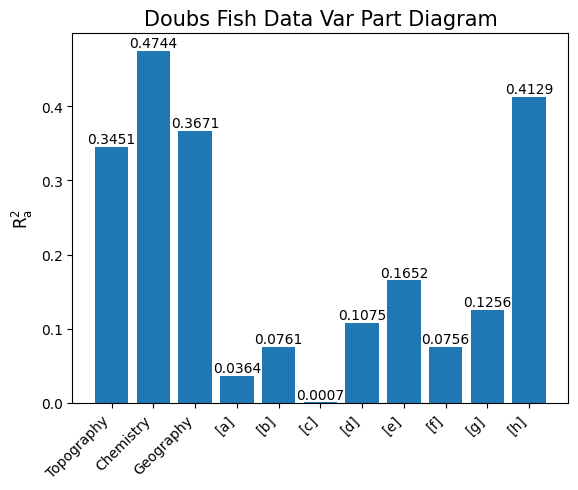

In [253]:
style = 'bar'
R2_list, venn_dict = varpart(Y,variables,X_labels=str_variables,title='Doubs Fish Data Var Part Diagram',save_path=f'./doubs_varpart_{style}.svg',diagram=style)

In [254]:
venn_dict_legendre = {
    ('Topography',): .345,
    ('Chemistry',): .474,
    ('Geography',): .367,
    ('Topography', 'Chemistry'): .586,
    ('Topography', 'Geography'): .511,
    ('Chemistry', 'Geography'): .551,
    ('Topography', 'Chemistry', 'Geography'): .587
}

for key in venn_dict_legendre:
    print(f'% error for {key} = {np.round(100*((venn_dict[key]/venn_dict_legendre[key])-1),3)}%')

% error for ('Topography',) = 0.029%
% error for ('Chemistry',) = 0.084%
% error for ('Geography',) = 0.027%
% error for ('Topography', 'Chemistry') = 0.068%
% error for ('Topography', 'Geography') = 0.0%
% error for ('Chemistry', 'Geography') = -0.054%
% error for ('Topography', 'Chemistry', 'Geography') = 0.017%


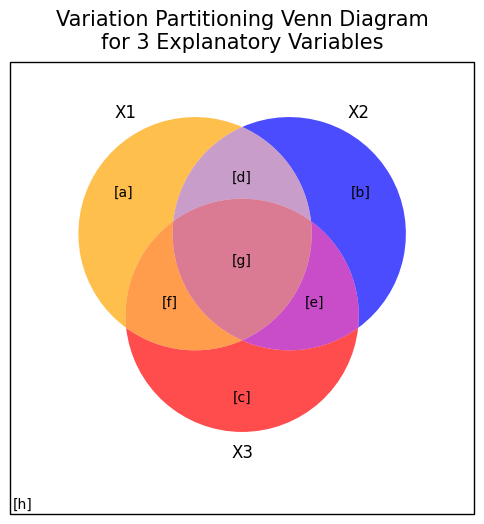

In [255]:
labels = ['X1','X2','X3']
v = venn3(subsets=[1]*7,set_labels=labels,set_colors=("orange", "blue", "red"), alpha=0.7)

subsets_str = ['a','b','c','d','e','f','g']
pos = ['100','010','001','110','011','101','111']

for i in range(len(pos)):
    v.get_label_by_id(pos[i]).set_text(f'[{subsets_str[i]}]')

fig = plt.gcf()
ax = plt.gca()

rect_coord = (np.min(ax.get_xlim())-.15,np.min(ax.get_ylim())-.2)
rect = plt.Rectangle(rect_coord,
                        width  = np.max(ax.get_xlim())-np.min(ax.get_xlim()) + 0.15*2,
                        height = np.max(ax.get_ylim())-np.min(ax.get_ylim()) + 0.3,
                        edgecolor='k',ls='-',lw=1,facecolor='none',clip_on=False)

ax.add_patch(rect)
ax.text(rect_coord[0]+0.01,rect_coord[1]+0.02,f'[h]')

ax.text(np.mean(plt.xlim()),np.max(plt.ylim())+.15,'Variation Partitioning Venn Diagram\nfor 3 Explanatory Variables',fontsize=15,ha='center')
fig.savefig('example_venn.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')